# Processing steps for correcting clipped data
Sept 18 2023

This notebook uses data from ApRES station A101 from 2021-2022, and illustrates how clipped data shows up when determining reflector profiles. It also shows how a correction can be applied to remove a majority of the effects.

First, let's load the relevant libraries and set up a dask cluster to help with computation.

In [1]:
# Setting up environment
import sys
import pandas as pd
sys.path.append("../../xapres_package/")
import ApRESDefs
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import importlib
import gcsfs
import math

importlib.reload(ApRESDefs)
xa = ApRESDefs.xapres(loglevel='debug')

DEBUG    20:32:25 	 ApRESDefs.py @function _setup_logging line 539 - Stream logging level set to DEBUG
DEBUG    20:32:25 	 ApRESDefs.py @function _setup_logging line 540 - Add console handler to logger
DEBUG    20:32:25 	 ApRESDefs.py @function _setup_logging line 553 - File logging level set to DEBUG


In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:43613")
client

<Client: 'tcp://127.0.0.1:43613' processes=4 threads=16, memory=125.81 GiB>

Now we load in our data that we've saved onto a Google bucket.

In [3]:
# load relevant data
def reload(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        chunks={}) 
    return ds

def reload_winter(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}_winter22_23'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        consolidated=True, 
        chunks={}) 
    return ds

ds_101 = reload("A101")
ds_101_w = reload_winter("A101")
ds_101 = xr.concat([ds_101.isel(attenuator_setting_pair=1),ds_101_w.isel(attenuator_setting_pair=1)],'time')
ds_101.nbytes/1e9

299.545784588

We see this is 200 Gb of data for just the summer. A useful feature with dask is that we've lazily loaded it, so it's not occupying all of our disk space. Our next block of code selects the relevant parts of data that we need, and loads it locally.

It might be difficult explaining the more subtly clipped data from the lower gain setting (which is the only consistent setting across the seasons. Thus I will be moving forward with just the summer 21 data for this notebook. Let's plot this out.

In [4]:
ds_crop = ds_101.isel(time=range(100,len(ds_101.time)))
timeseries = ds_crop.profile_stacked.compute()
mean_chirp = abs(ds_crop.chirp).mean(dim=['chirp_time','chirp_num']).compute()

/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 10.41 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 10.58 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


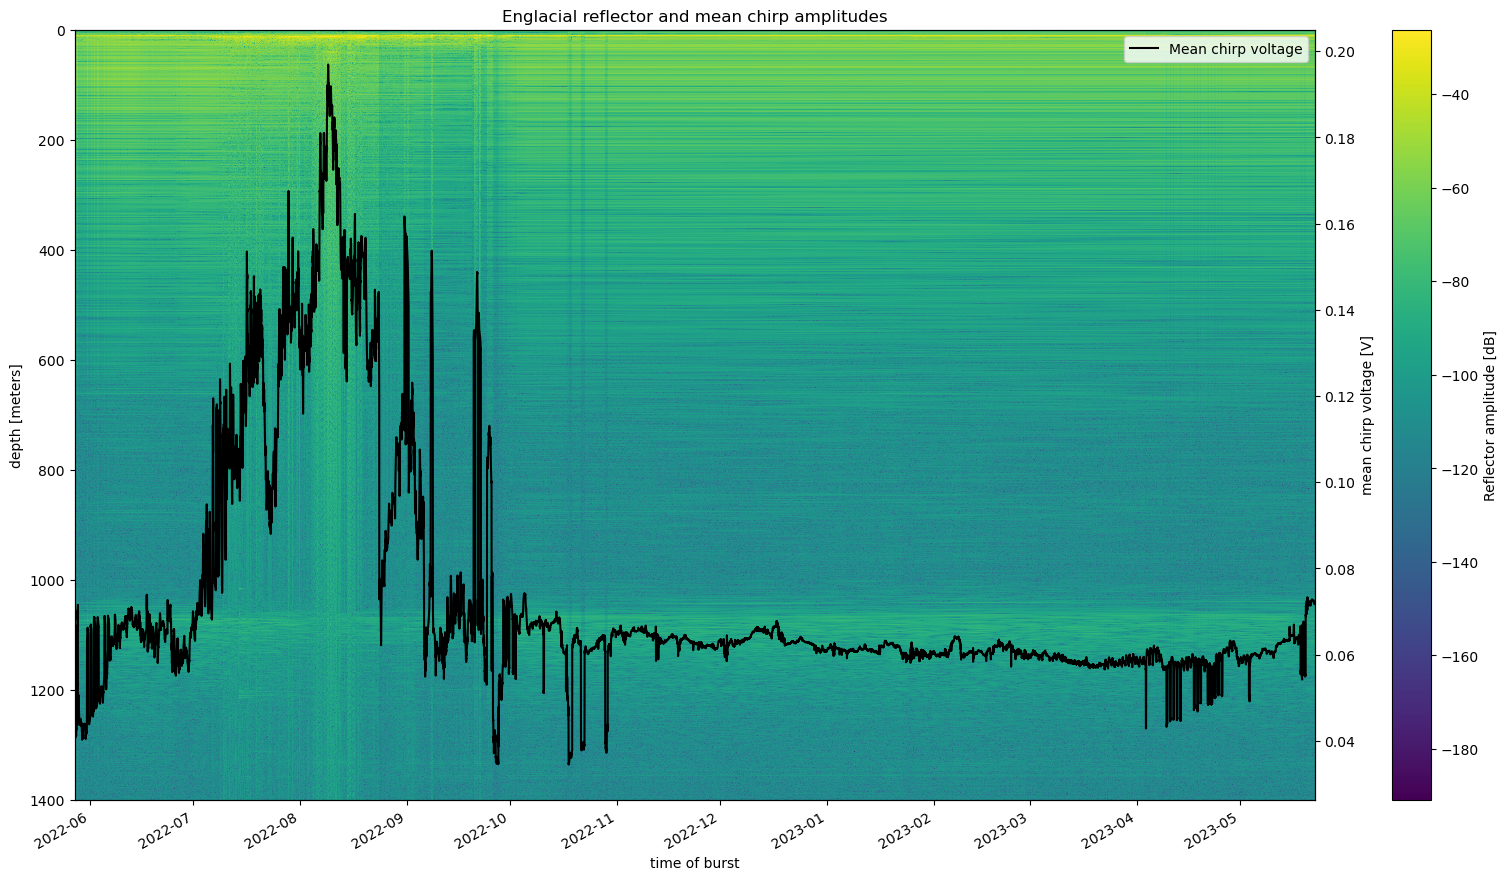

In [5]:
fig, ax = plt.subplots(figsize=(20,10))
xa.dB(timeseries).plot(ax=ax,x='time',cbar_kwargs={'label':'Reflector amplitude [dB]'})
ax.invert_yaxis()
ax2 = ax.twinx()
mean_chirp.plot(ax=ax2,color='black',label = 'Mean chirp voltage')
ax.set_title("Englacial reflector and mean chirp amplitudes")
plt.xlabel('date')
ax2.set_ylabel('mean chirp voltage [V]')
ax2.set_title('')

ax2.legend()

We see that the times where the chirp has a high mean amplitude (meaning most likely portions are clipped) are where there are bright vertical striping artifacts in the profiles. Now, we note that it's the front half of the chirp that has this large amplitude typically, as illustrated in the next plot.

/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 10.72 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 10.63 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 10.63 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 10.63 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Text(0.5, 53.53536656924006, 'time of burst')

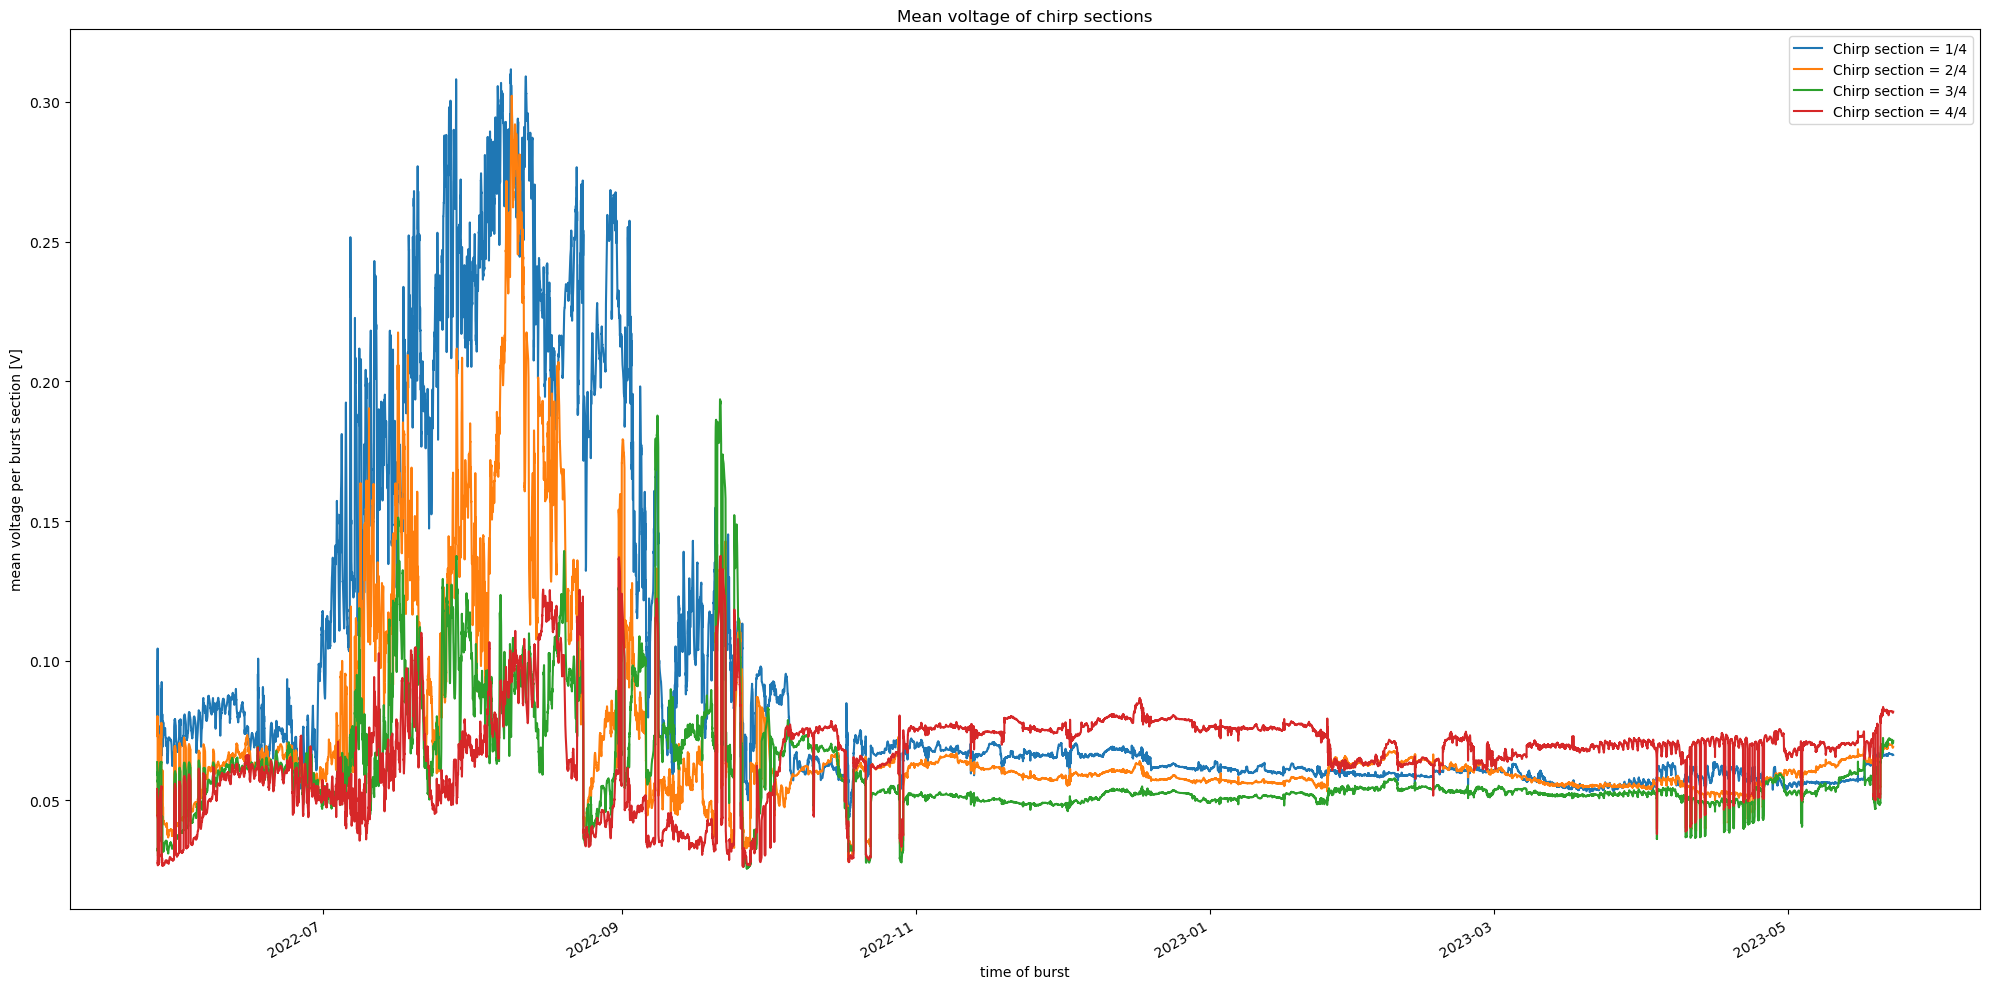

In [6]:
fig, ax = plt.subplots(figsize=(20,10))

freq_ranges = np.arange(0,40001,10000)
for i in range(1,len(freq_ranges)):
    to_plot = abs(ds_crop.chirp.isel(chirp_time=range(freq_ranges[i-1],freq_ranges[i]))).mean(dim=['chirp_time','chirp_num']).compute()
    to_plot.plot(ax=ax,label = f'Chirp section = {i}/{len(freq_ranges)-1}')

ax.set_title('Mean voltage of chirp sections')
ax.set_ylabel('mean voltage per burst section [V]')
ax.legend()
plt.tight_layout()
plt.xlabel('time of burst')

Now to correct this, we use the second half of each chirp when calculating the profiles. We define a custom function for this that allows us to specify the range of chirp frequencies to use.

In [7]:
# define function
def custom_stacked_profile_series(chirps,pad=2,F0=2e8,F1=4e8):
    StartFreq = 2e8
    StopFreq = 4e8
    B = StopFreq - StartFreq
    CentreFreq = B/2
    K = 2e8 
    dt = 1/40000
    c0 = 3e8 # speed of light in vaccuum
    ER_ICE = 3.18
    T0 = (F0-StartFreq)/K
    T1 = (F1-StartFreq)/K

    chirps = chirps.isel(chirp_time=range(math.ceil(T0/dt),math.floor(T1/dt)+1)).mean(dim='chirp_num')
    window = np.blackman(len(chirps.chirp_time))
    win_chirps = chirps*window
    Nt = len(chirps.chirp_time)
    Nfft = math.floor(Nt*pad)
    bin2m = c0/(2.*(T1-T0)*pad*math.sqrt(ER_ICE)*K)
    profile_range = np.asarray([i for i in range(Nfft)]) * bin2m      
    profile_range = profile_range[0:math.floor(Nfft/2)-1]
    padchirp = np.zeros((len(chirps.time),Nfft))
    padchirp[:,0:math.floor(Nt/2)] = win_chirps.data[:,math.floor(Nt/2):-1]
    padchirp[:,-math.floor(Nt/2):] = win_chirps.data[:,0:math.floor(Nt/2)]
    p = np.fft.fft(padchirp,axis=1)/Nfft * math.sqrt(2*pad)
    profile = p[:,0:math.floor(Nfft/2)-1]
    m = np.asarray([i for i in range(profile.shape[1])])/pad
    phiref = 2*math.pi*CentreFreq*m/B - m * m * 2*math.pi * K/2/B**2
    profile_ref = profile * np.exp(phiref[np.newaxis,:]*(-1j))
    profile_range = np.asarray([i for i in range(Nfft)]) * bin2m      
    profile_range = profile_range[0:math.floor(Nfft/2)-1]
    n = np.argmin(profile_range<=1400)
    Range = profile_range[:n]
    Profile = profile_ref[:,:n]
    da = xr.DataArray(Profile,
                  dims=['time','profile_range'],
                  coords={'profile_range': Range,
                         'time': chirps.time.data})
    return da

Calculating it using dask. Again this highlights the utility of cloud computing as all the calculations are done over the cloud without taking up much memory locally. It's only once it's finished does the relevant data get loaded.

In [8]:
da_101_stacked  = custom_stacked_profile_series(ds_crop.chirp,2,3e8,4e8)


Now we plot the new profiles with our applied correction. It's not perfect, but the months of July and August are a lot cleaner now. There's still some streaks in late August and September. I suspect that there was water pooling under the antennas, or seperation of antennas from the ice.

Text(0.5, 0, 'date')

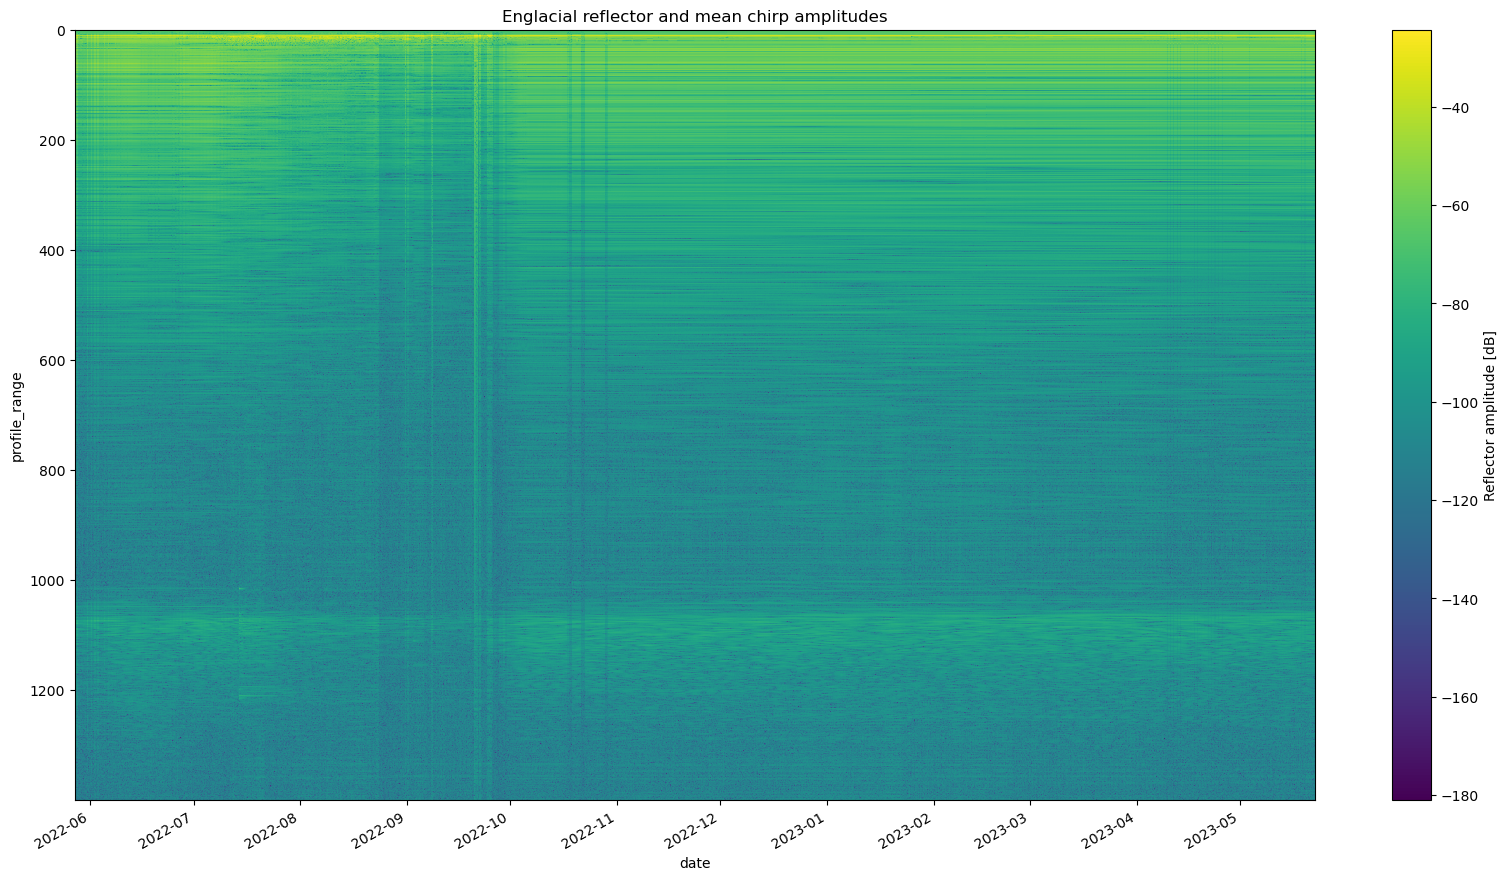

In [9]:
fig, ax = plt.subplots(figsize=(20,10))
xa.dB(da_101_stacked).plot(ax=ax,x='time',cbar_kwargs={'label':'Reflector amplitude [dB]'})
ax.invert_yaxis()
ax.set_title("Englacial reflector amplitudes")
plt.xlabel('date')


Let's see how this data cleaning impacts strain rate calculations. First with clipping.


In [10]:
ts_resample = timeseries.resample(time='30T').mean(dim='time')
b1 = ts_resample.isel(time=range(0,len(ts_resample.time)-1)).where(ts_resample.profile_range >= 5,drop=True)
b2 = ts_resample.isel(time=range(1,len(ts_resample.time))).where(ts_resample.profile_range >= 5,drop=True)
ds, co, phi = xa.generate_range_diff(b1,b2,20,20,None,0,0.9)

INFO     21:16:10 	 ApRESDefs.py @function generate_range_diff line 594 - Time between bursts : [1800. 1800. 1800. ... 1800. 1800. 1800.]s


/home/jovyan/xapres_package/notebooks/test_notes/../../xapres_package/ApRESDefs.py:579: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


The displacements seem wildy large. No way did the ice move 10 meters. There could be some issues with our displacement calculations, so these need to be taken with a grain of salt. However, the messy displacements only really start once the vertical streaks start appearing in the profile plot.

Text(0, 0.5, 'depth [m], displacement [cm]')

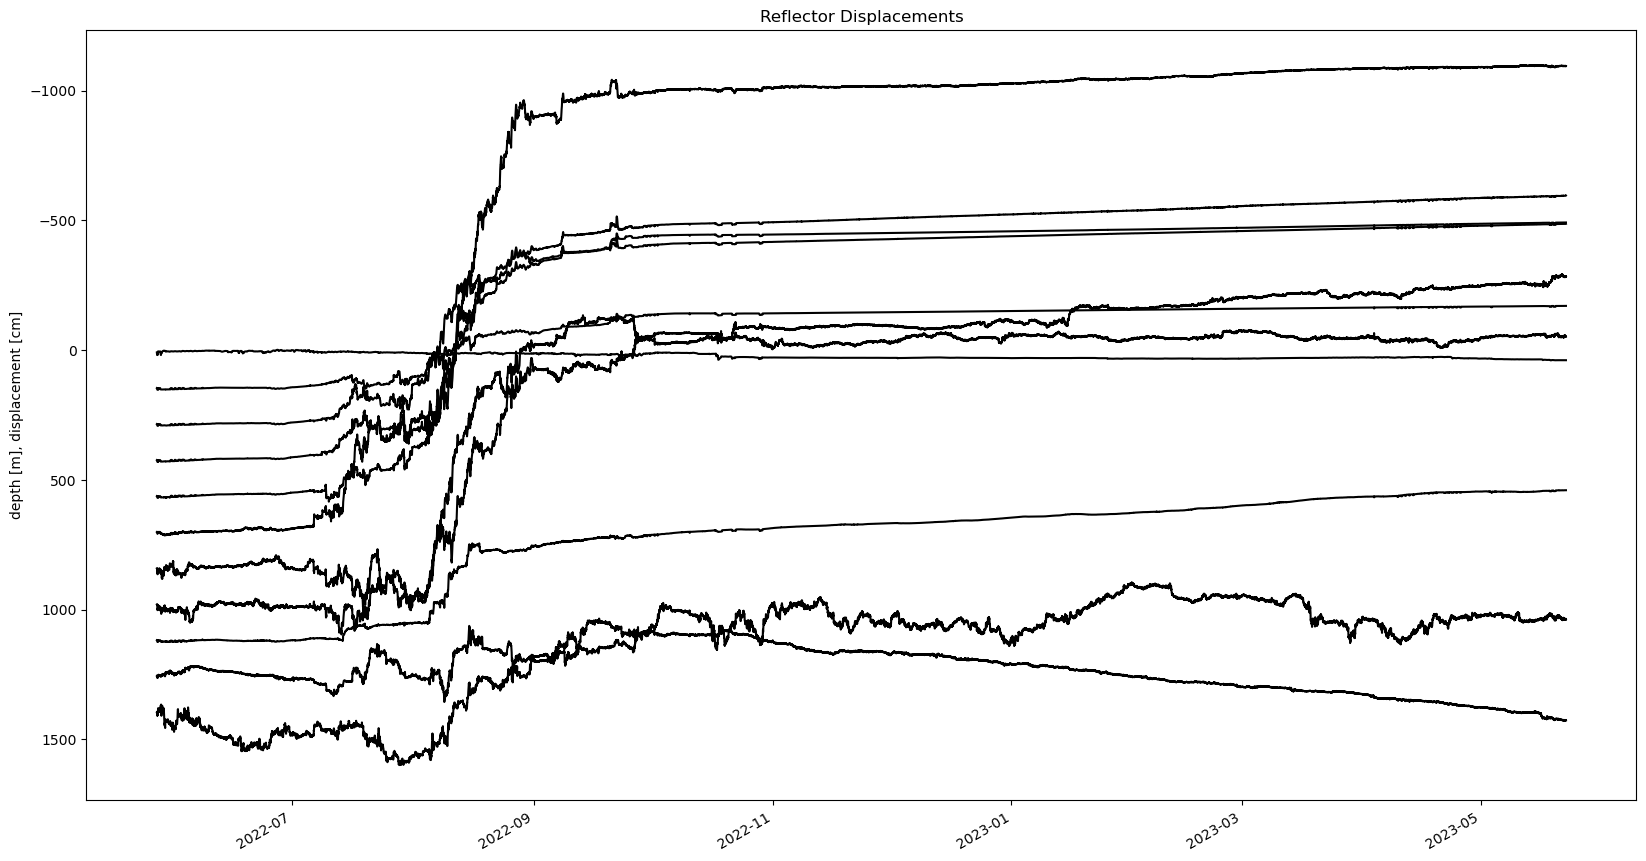

In [11]:
fig, ax = plt.subplots(figsize=(20,10))
for i in np.arange(0,len(ds.profile_range),len(ds.profile_range)//10):
    (100*ds.range_diff.cumsum(dim='time').isel(profile_range = i) + ds.profile_range.isel(profile_range = i)).plot(ax=ax,color='k')
ax.invert_yaxis()
ax.set_title('Reflector Displacements')
ax.set_xlabel('')
ax.set_ylabel('depth [m], displacement [cm]')

In [12]:
def convert_to_seconds(s):
    seconds_per_unit = {"S": 1, "M": 60, "H": 3600, "D": 86400, "W": 604800}
    return int(s[:-1]) * seconds_per_unit[s[-1]]

def sum_error(errs):
    return np.sqrt(np.sum(errs**2))

def error_prop(data):
    return xr.apply_ufunc(sum_error, data, input_core_dims=[["time"]], vectorize = True)

disp_stack = ds.range_diff.resample(time='1W').sum(dim='time')/convert_to_seconds('1W')*31536000
strain_polyfit = disp_stack.where(disp_stack.profile_range <= 500,drop=True).polyfit('profile_range',1)
err_stack = ds.err.resample(time='1W').apply(error_prop)/convert_to_seconds('1W')*31536000

Plotting selected vertical velocities with fitted strain rates. We see it gets extremely noisy.

Text(0.5, 0.01, 'vertical velocity [m y$^{-1}$]')

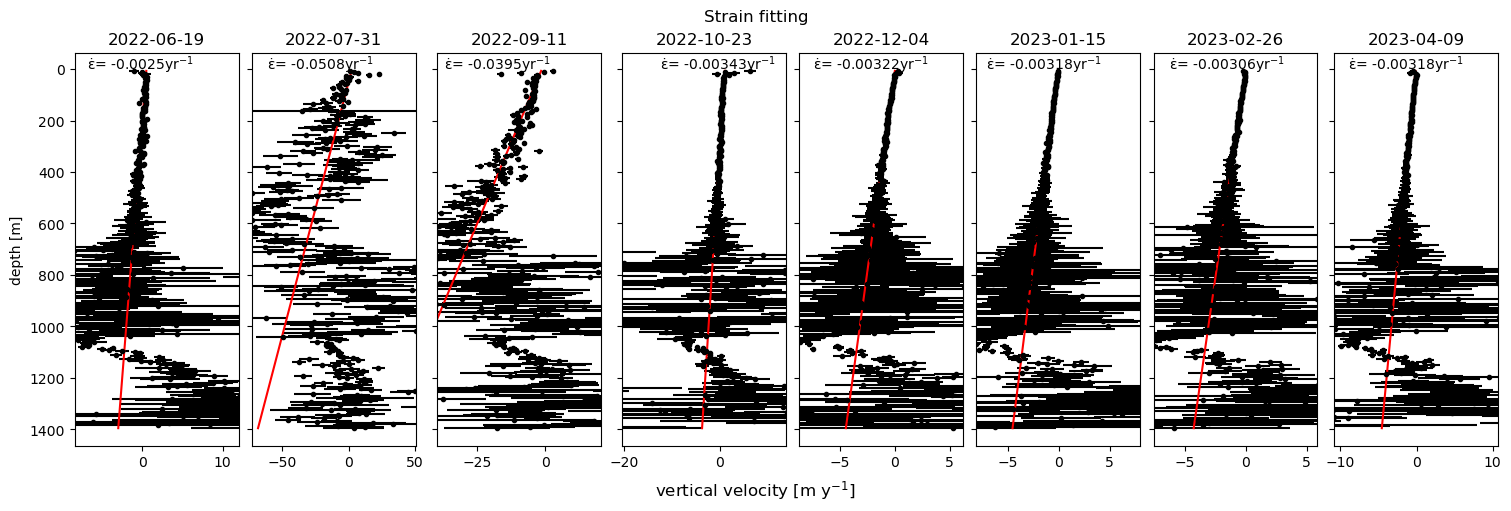

In [13]:
fig1, axs_1 = plt.subplots(ncols=8,figsize=(15,5),sharey=True,layout='constrained')
fig1.suptitle('Strain fitting')
# Plotting displacement for individual layers 
plt_count = 0
for i in np.arange(math.ceil(0.05*len(disp_stack.time)),len(disp_stack.time),len(disp_stack.time)//8):
    axs_1[plt_count].errorbar(disp_stack.isel(time = i) ,disp_stack.profile_range,yerr=None,xerr=err_stack.isel(time = i),linestyle='',marker='.',color='k')
    fit = strain_polyfit.polyfit_coefficients.sel(degree=1).isel(time=i)*disp_stack.profile_range+strain_polyfit.polyfit_coefficients.sel(degree=0).isel(time=i)

    axs_1[plt_count].plot(fit,disp_stack.profile_range,color='r')
    unit = 'yr$^{-1}$'
    axs_1[plt_count].text(np.percentile(disp_stack.isel(time = i),7),0, f"\u03B5\u0307= {strain_polyfit.polyfit_coefficients.sel(degree=1).isel(time=i).values:.3g}"+unit)
    axs_1[plt_count].set_title(f'{disp_stack.time.isel(time = i).values.astype(str)[:10]}')
    axs_1[plt_count].set_xlim(np.percentile(disp_stack.isel(time = i),[5,95]))
    plt_count += 1
    if plt_count == 8:
        break

axs_1[0].invert_yaxis()

axs_1[0].set_ylabel('depth [m]')
fig1.supxlabel('vertical velocity [m y$^{-1}$]')

Now Let's do the same with our cleaner data.

In [14]:
ts_resample = da_101_stacked.resample(time='3H').mean(dim='time')

b1 = ts_resample.isel(time=range(0,len(ts_resample.time)-1)).where(ts_resample.profile_range >= 10,drop=True)
b2 = ts_resample.isel(time=range(1,len(ts_resample.time))).where(ts_resample.profile_range >= 10,drop=True)
ds, co, phi = xa.generate_range_diff(b1,b2,20,20,None,0,0.97)

INFO     21:16:43 	 ApRESDefs.py @function generate_range_diff line 594 - Time between bursts : [10800. 10800. 10800. ... 10800. 10800. 10800.]s


Plotting displacements looks slightly better.

Text(0, 0.5, 'depth [m], displacement [cm]')

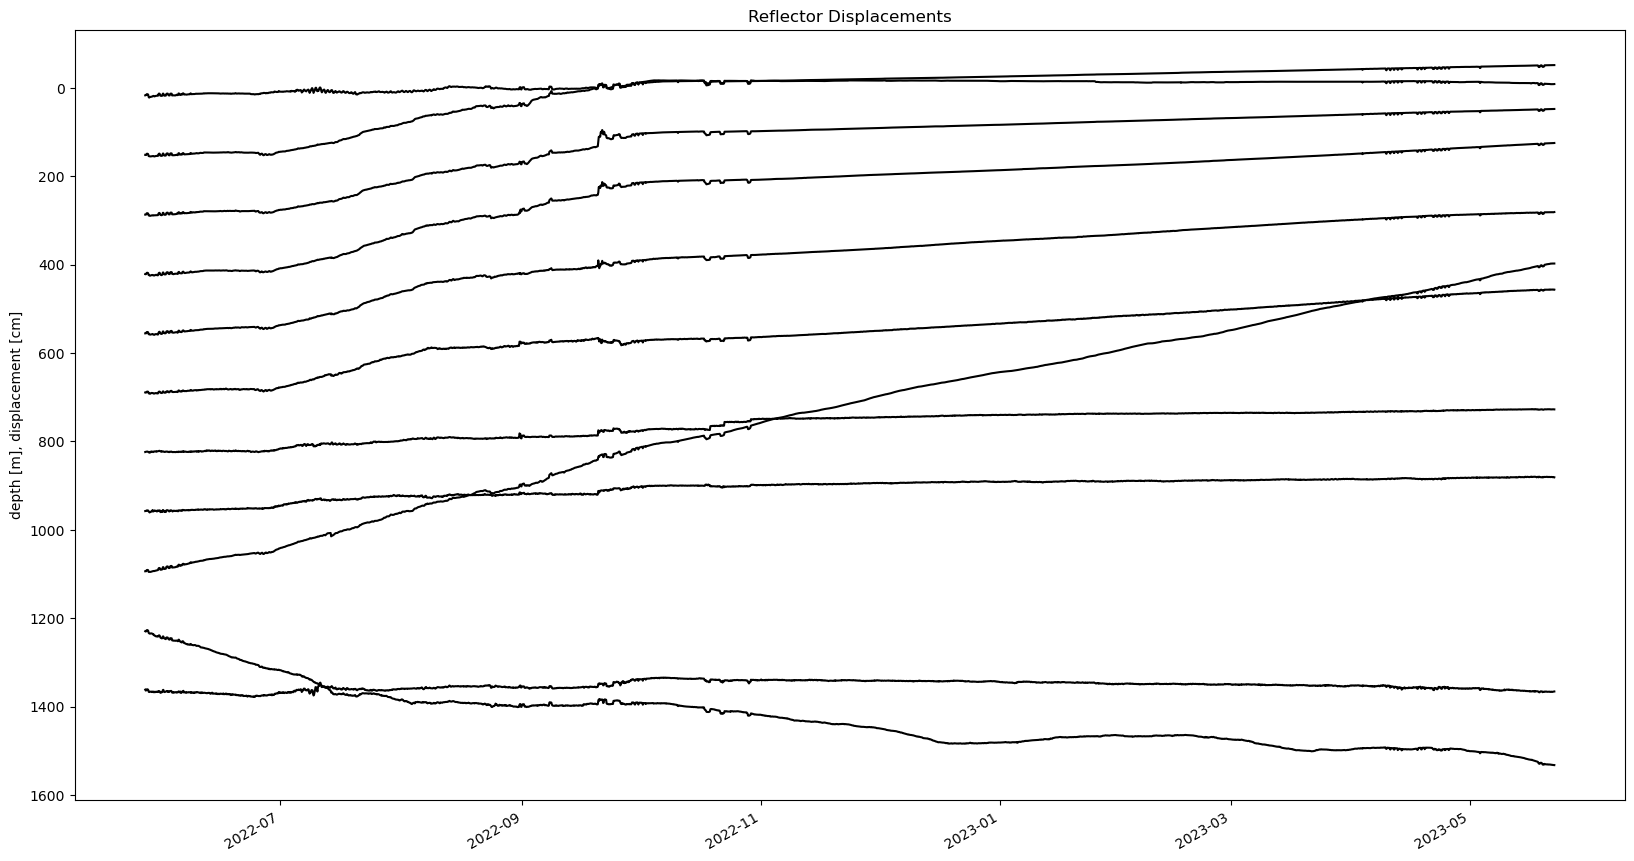

In [15]:
fig, ax = plt.subplots(figsize=(20,10))
for i in np.arange(0,len(ds.profile_range),len(ds.profile_range)//10):
    (100*ds.range_diff.cumsum(dim='time').isel(profile_range = i) + ds.profile_range.isel(profile_range = i)).plot(ax=ax,color='k')
ax.invert_yaxis()
ax.set_title('Reflector Displacements')
ax.set_xlabel('')
ax.set_ylabel('depth [m], displacement [cm]')

And in comparison, so do the vertical velocities and strain rates.

Text(0.5, 0.01, 'vertical velocity [m y$^{-1}$]')

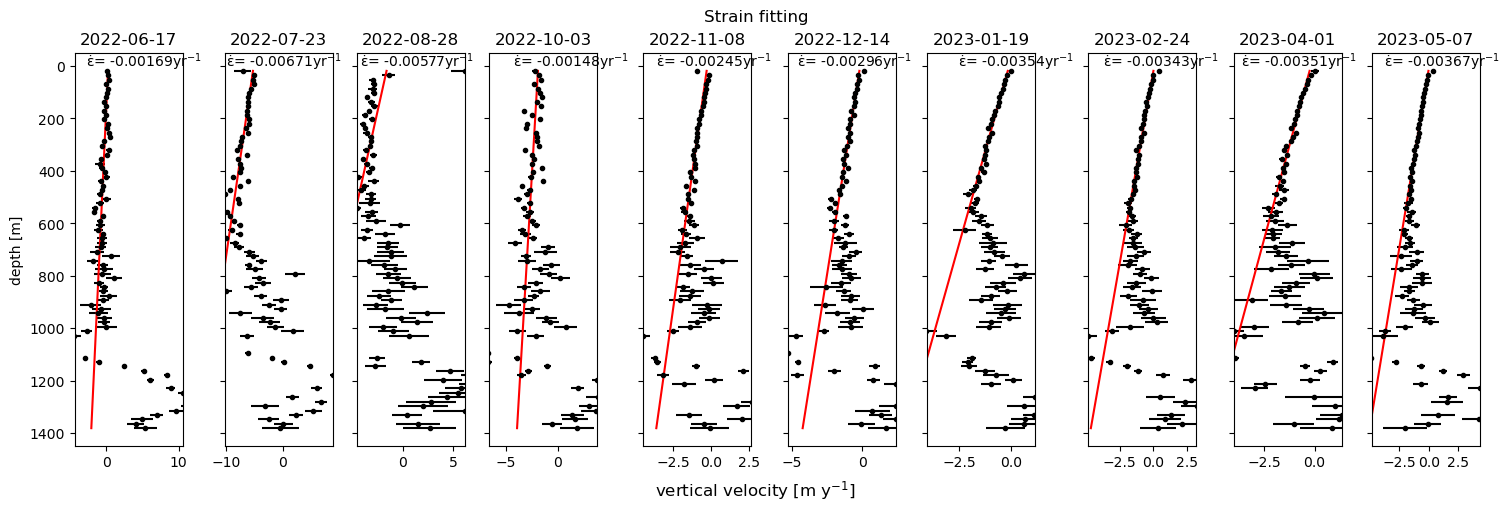

In [16]:

disp_stack = ds.range_diff.resample(time='3D').sum(dim='time')/convert_to_seconds('3D')*31536000
disp_stack = disp_stack.coarsen(profile_range=2,boundary='trim').mean()
err_stack = ds.err.resample(time='3D').apply(error_prop)/convert_to_seconds('3D')*31536000
err_stack = np.sqrt((err_stack**2).coarsen(profile_range=2,boundary='trim').sum())/2
strain_polyfit = disp_stack.where(disp_stack.profile_range <= 500,drop=True).polyfit('profile_range',1)

fig1, axs_1 = plt.subplots(ncols=10,figsize=(15,5),sharey=True,layout='constrained')
fig1.suptitle('Strain fitting')
# Plotting displacement for individual layers 
plt_count = 0
for i in np.arange(math.ceil(0.05*len(disp_stack.time)),len(disp_stack.time),len(disp_stack.time)//10):
    axs_1[plt_count].errorbar(disp_stack.isel(time = i) ,disp_stack.profile_range,yerr=None,xerr=err_stack.isel(time = i),linestyle='',marker='.',color='k')
    fit = strain_polyfit.polyfit_coefficients.sel(degree=1).isel(time=i)*disp_stack.profile_range+strain_polyfit.polyfit_coefficients.sel(degree=0).isel(time=i)

    axs_1[plt_count].plot(fit,disp_stack.profile_range,color='r')
    unit = 'yr$^{-1}$'
    axs_1[plt_count].text(np.percentile(disp_stack.isel(time = i),7),0, f"\u03B5\u0307= {strain_polyfit.polyfit_coefficients.sel(degree=1).isel(time=i).values:.3g}"+unit)
    axs_1[plt_count].set_title(f'{disp_stack.time.isel(time = i).values.astype(str)[:10]}')
    axs_1[plt_count].set_xlim(np.percentile(disp_stack.isel(time = i),[5,95]))
    plt_count += 1
    if plt_count == 10:
        break

axs_1[0].invert_yaxis()

axs_1[0].set_ylabel('depth [m]')
fig1.supxlabel('vertical velocity [m y$^{-1}$]')

Checking around lake drainage

Text(0.5, 0, 'date')

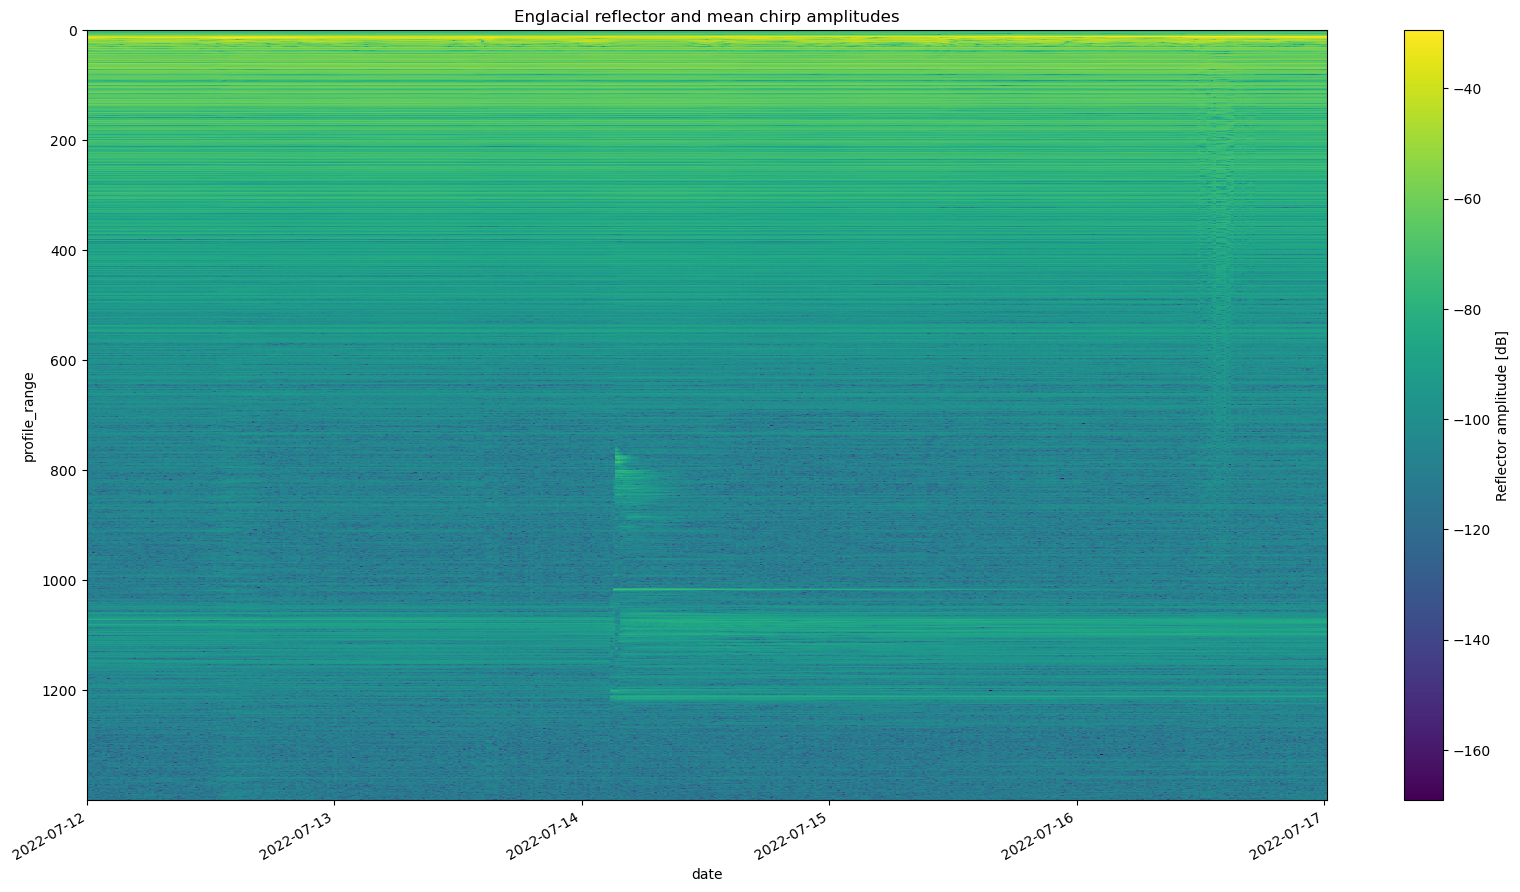

In [39]:
date_range = xr.date_range('2022-07-12T00:00:00.000000000','2022-07-17T00:00:00.000000000',freq='15T')
fig, ax = plt.subplots(figsize=(20,10))
xa.dB(da_101_stacked.sel(time=date_range,method='nearest')).plot(ax=ax,x='time',cbar_kwargs={'label':'Reflector amplitude [dB]'})
ax.invert_yaxis()
ax.set_title("Englacial reflector and mean chirp amplitudes")
plt.xlabel('date')



INFO     22:35:26 	 ApRESDefs.py @function generate_range_diff line 594 - Time between bursts : [3600. 3600. 3600. 3600. 3600. 3600. 3600. 3600. 3600. 3600. 3600. 3600.
 3600. 3600. 3600. 3600. 3600. 3600. 3600. 3600. 3600. 3600. 3600. 3600.
 3600. 3600. 3600. 3600. 3600. 3600. 3600. 3600. 3600. 3600. 3600. 3600.
 3600. 3600. 3600. 3600. 3600. 3600. 3600. 3600. 3600. 3600. 3600. 3600.
 3600. 3600. 3600. 3600. 3600. 3600. 3600. 3600. 3600. 3600. 3600. 3600.
 3600. 3600. 3600. 3600. 3600. 3600. 3600. 3600. 3600. 3600. 3600. 3600.
 3600. 3600. 3600. 3600. 3600. 3600. 3600. 3600. 3600. 3600. 3600. 3600.
 3600. 3600. 3600. 3600. 3600. 3600. 3600. 3600. 3600. 3600. 3600. 3600.
 3600. 3600. 3600. 3600. 3600. 3600. 3600. 3600. 3600. 3600. 3600. 3600.
 3600. 3600. 3600. 3600. 3600. 3600. 3600. 3600. 3600. 3600. 3600. 3600.]s


Text(0, 0.5, 'depth [m], displacement [cm]')

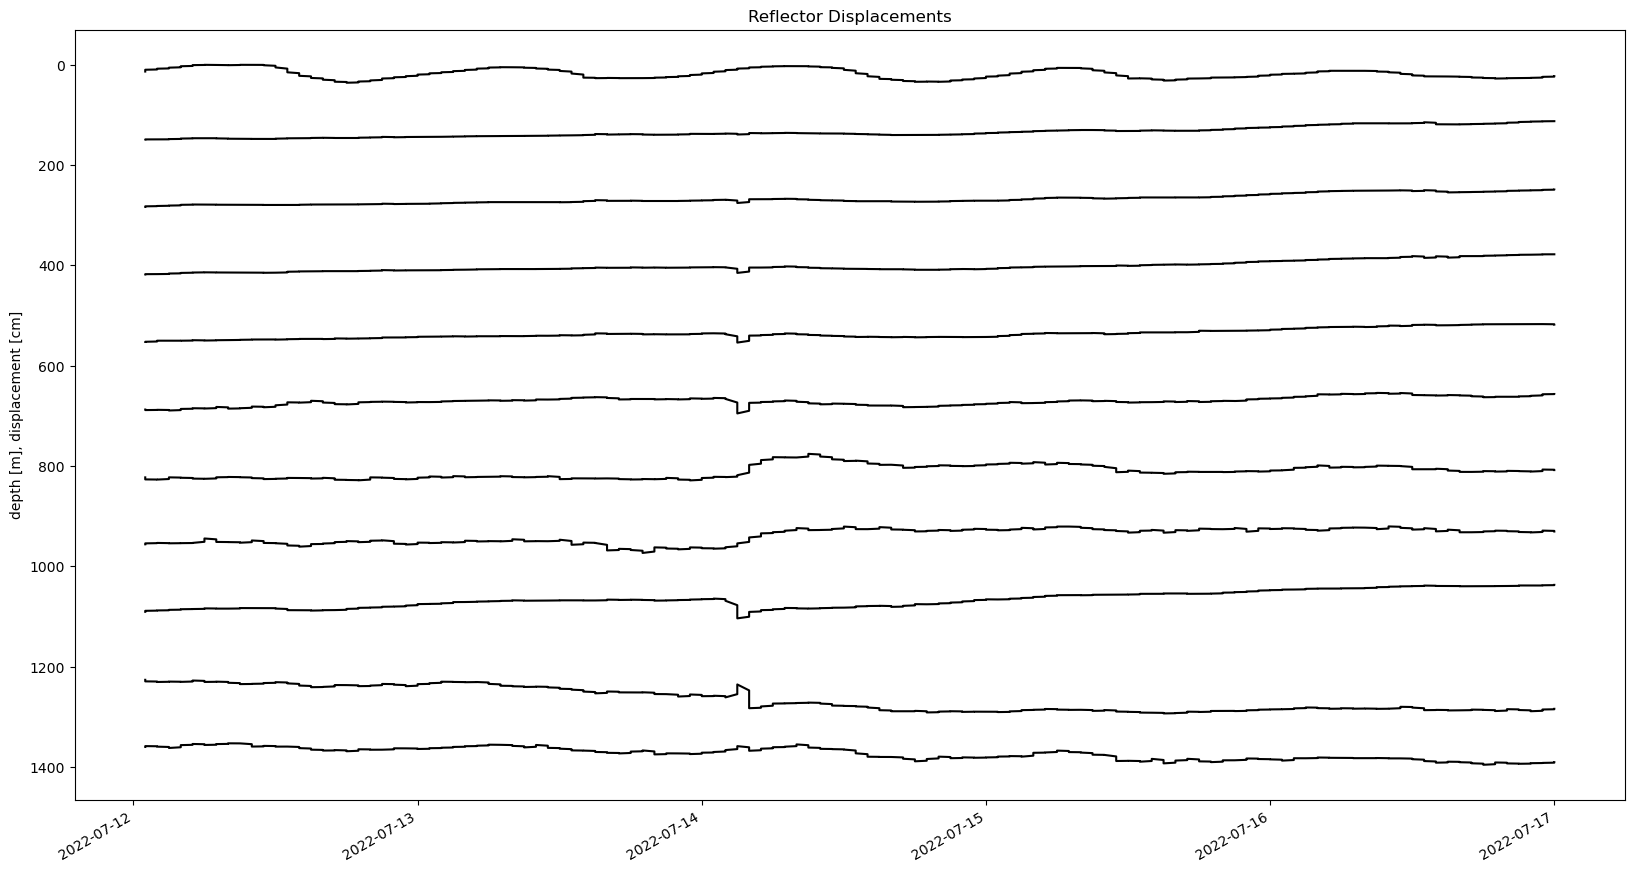

In [48]:
ts_resample = da_101_stacked.sel(time=date_range,method='nearest').resample(time='1H').mean(dim='time')

b1 = ts_resample.isel(time=range(0,len(ts_resample.time)-1)).where(ts_resample.profile_range >= 10,drop=True)
b2 = ts_resample.isel(time=range(1,len(ts_resample.time))).where(ts_resample.profile_range >= 10,drop=True)
ds, co, phi = xa.generate_range_diff(b1,b2,20,20,None,0,0.97)
fig, ax = plt.subplots(figsize=(20,10))
for i in np.arange(0,len(ds.sel(time=date_range,method='nearest').profile_range),len(ds.sel(time=date_range,method='nearest').profile_range)//10):
    (100*ds.sel(time=date_range,method='nearest').range_diff.cumsum(dim='time').isel(profile_range = i) + ds.sel(time=date_range,method='nearest').profile_range.isel(profile_range = i)).plot(ax=ax,color='k')
ax.invert_yaxis()
ax.set_title('Reflector Displacements')
ax.set_xlabel('')
ax.set_ylabel('depth [m], displacement [cm]')

Text(0.5, 0.01, 'vertical velocity [m y$^{-1}$]')

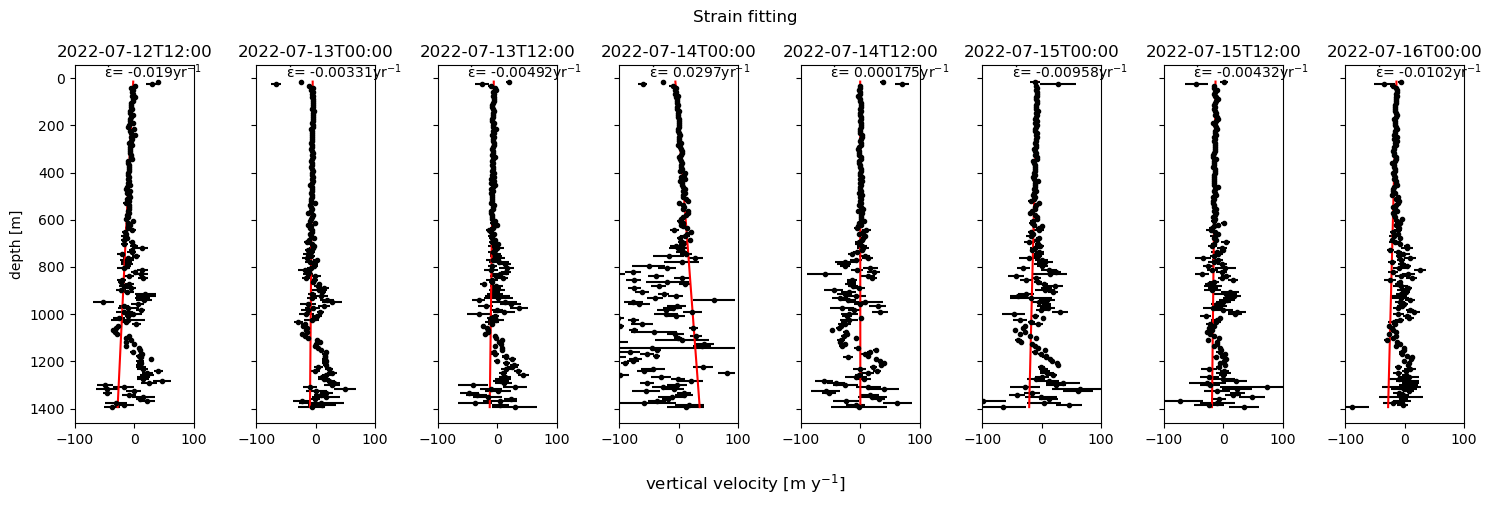

In [52]:

disp_stack = ds.range_diff.resample(time='12H').sum(dim='time')/convert_to_seconds('12H')*31536000
disp_stack = disp_stack.coarsen(profile_range=1,boundary='trim').mean()
err_stack = ds.err.resample(time='12H').apply(error_prop)/convert_to_seconds('12H')*31536000
err_stack = np.sqrt((err_stack**2).coarsen(profile_range=1,boundary='trim').sum())/1
strain_polyfit = disp_stack.where(disp_stack.profile_range <= 500,drop=True).polyfit('profile_range',1,w=1/err_stack.where(disp_stack.profile_range <= 500,drop=True).mean(dim='time'))
fig1, axs_1 = plt.subplots(ncols=8,figsize=(15,5),sharey=True,layout='tight')
fig1.suptitle('Strain fitting')
# Plotting displacement for individual layers 
plt_count = 0
for i in np.arange(math.ceil(0.05*len(disp_stack.time)),len(disp_stack.time),len(disp_stack.time)//8):
    axs_1[plt_count].errorbar(disp_stack.isel(time = i) ,disp_stack.profile_range,yerr=None,xerr=err_stack.isel(time = i),linestyle='',marker='.',color='k')
    fit = strain_polyfit.polyfit_coefficients.sel(degree=1).isel(time=i)*disp_stack.profile_range+strain_polyfit.polyfit_coefficients.sel(degree=0).isel(time=i)

    axs_1[plt_count].plot(fit,disp_stack.profile_range,color='r')
    unit = 'yr$^{-1}$'
    axs_1[plt_count].text(-50,0, f"\u03B5\u0307= {strain_polyfit.polyfit_coefficients.sel(degree=1).isel(time=i).values:.3g}"+unit)
    axs_1[plt_count].set_title(f'{disp_stack.time.isel(time = i).values.astype(str)[:16]}')
    axs_1[plt_count].set_xlim([-100,100])
    plt_count += 1
    if plt_count == 8:
        break

axs_1[0].invert_yaxis()

axs_1[0].set_ylabel('depth [m]')
fig1.supxlabel('vertical velocity [m y$^{-1}$]')